# Loan Classification System using Decision Trees and Prolog Knowledge Base

This notebook implements a complete loan classification system that:
1. Builds a decision tree from loan data
2. Extracts rules from the decision tree
3. Converts rules to Prolog knowledge base
4. Provides user interface for loan classification

**Dataset Attributes:**
- Sex (Male/Female)
- Age 
- Loan Term in Years
- Number of Accounts
- Loan Type (Home/Personal/Auto/Education)
- Loan Area (Urban/Rural/Suburban)
- Loan Sanctioned (1=Success, 0=Rejected)

In [13]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [14]:
# Load and Explore the Dataset
# Load the loan dataset
df = pd.read_csv('data/Loan - Loan dataset.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

# Display unique values for categorical columns
categorical_cols = ['sex', 'Loan Type', 'Loan Area']
for col in categorical_cols:
    if col in df.columns:
        print(f"\nUnique values in {col}: {df[col].unique()}")

print(f"\nTarget variable distribution:")
print(df['Loan Sanctioned'].value_counts())
print(f"Approval rate: {df['Loan Sanctioned'].mean():.3f}")

Dataset loaded successfully!
Dataset shape: (90, 7)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   sex                 90 non-null     int64
 1   age                 90 non-null     int64
 2   Loan Term in Years  90 non-null     int64
 3   Number_of_Accounts  90 non-null     int64
 4   Loan Type           90 non-null     int64
 5   Loan Area           90 non-null     int64
 6   Loan Sanctioned     90 non-null     int64
dtypes: int64(7)
memory usage: 5.0 KB
None

First 5 rows:
   sex  age  Loan Term in Years  Number_of_Accounts  Loan Type  Loan Area  \
0    1   35                  12                   5          1        100   
1    2   29                   7                   5          1         96   
2    2   50                   8                   1          3        132   
3    2   32                  11           

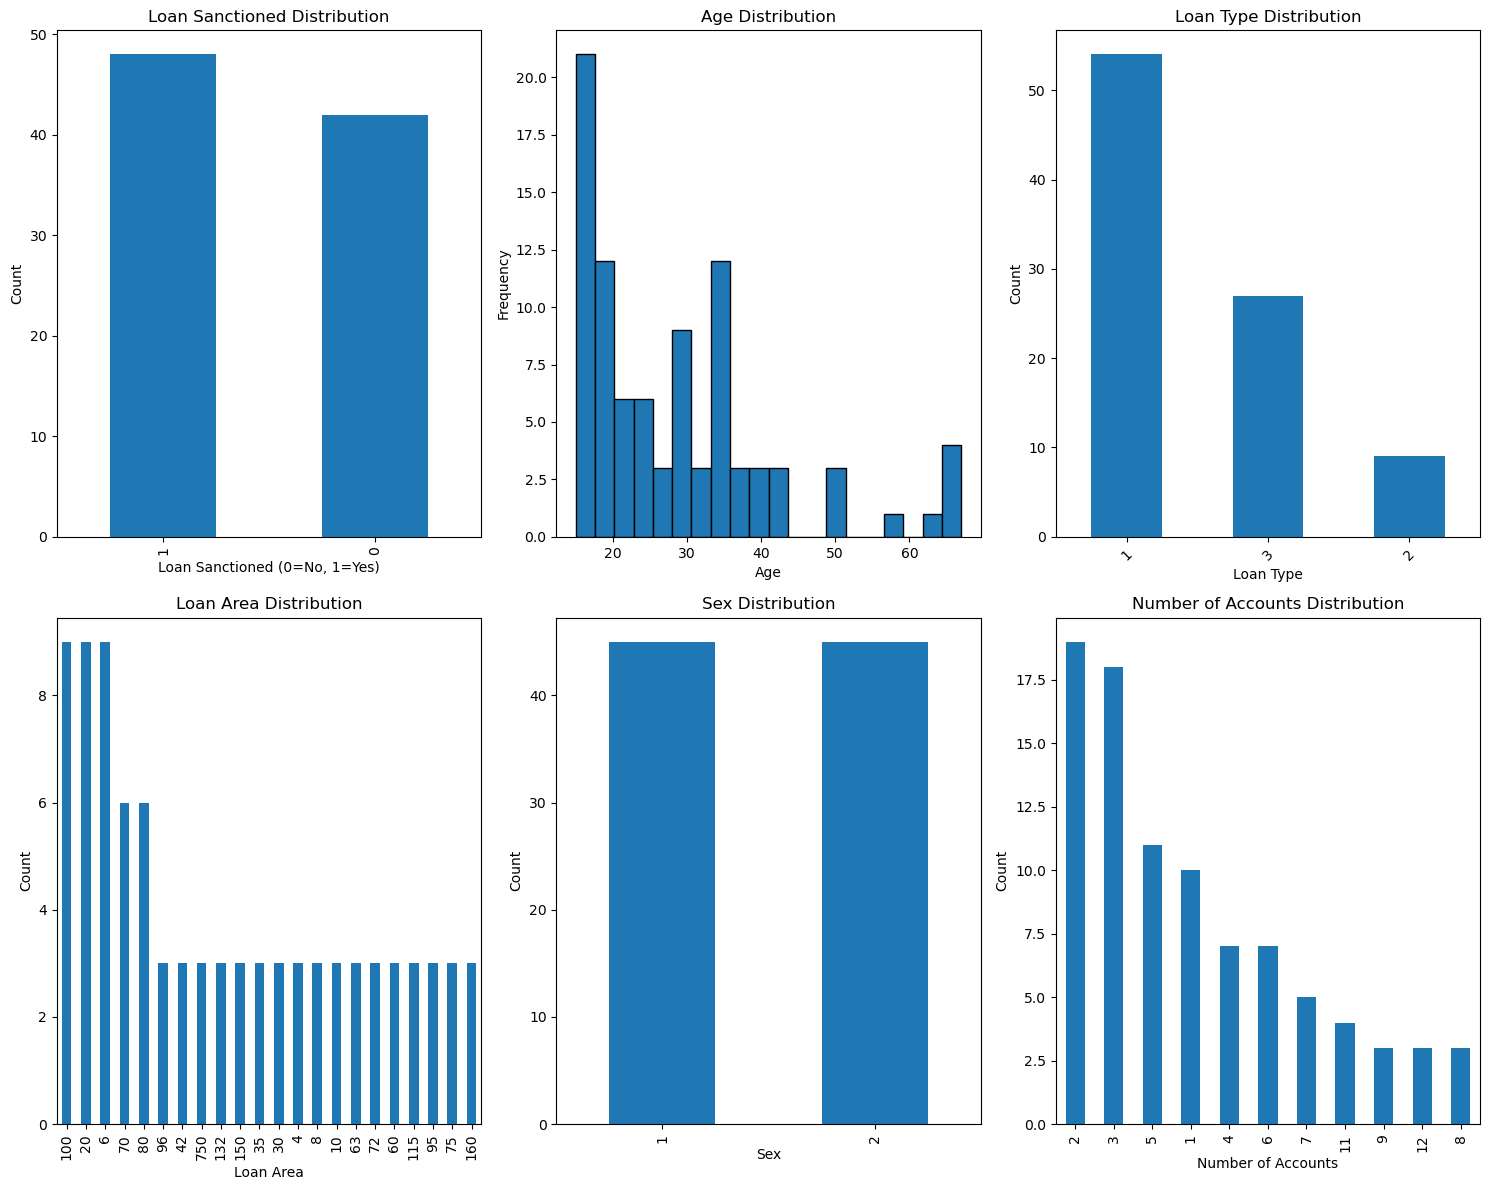


Loan Sanctioned Rate by Category:

sex:
sex
1    0.577778
2    0.488889
Name: Loan Sanctioned, dtype: float64

Loan Type:
Loan Type
1    0.703704
2    0.666667
3    0.148148
Name: Loan Sanctioned, dtype: float64

Loan Area:
Loan Area
4      1.000000
30     1.000000
70     1.000000
75     1.000000
60     1.000000
63     1.000000
160    1.000000
115    1.000000
96     0.666667
6      0.666667
20     0.555556
100    0.555556
80     0.500000
10     0.000000
8      0.000000
72     0.000000
42     0.000000
35     0.000000
95     0.000000
132    0.000000
150    0.000000
750    0.000000
Name: Loan Sanctioned, dtype: float64


In [15]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 12))

# Target variable distribution
plt.subplot(2, 3, 1)
df['Loan Sanctioned'].value_counts().plot(kind='bar')
plt.title('Loan Sanctioned Distribution')
plt.xlabel('Loan Sanctioned (0=No, 1=Yes)')
plt.ylabel('Count')

# Age distribution
plt.subplot(2, 3, 2)
plt.hist(df['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Loan Type distribution
plt.subplot(2, 3, 3)
df['Loan Type'].value_counts().plot(kind='bar')
plt.title('Loan Type Distribution')
plt.xlabel('Loan Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Loan Area distribution
plt.subplot(2, 3, 4)
df['Loan Area'].value_counts().plot(kind='bar')
plt.title('Loan Area Distribution')
plt.xlabel('Loan Area')
plt.ylabel('Count')

# Sex distribution
plt.subplot(2, 3, 5)
df['sex'].value_counts().plot(kind='bar')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')

# Number of Accounts distribution
plt.subplot(2, 3, 6)
df['Number_of_Accounts'].value_counts().plot(kind='bar')
plt.title('Number of Accounts Distribution')
plt.xlabel('Number of Accounts')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Correlation with target variable
print("\nLoan Sanctioned Rate by Category:")
for col in ['sex', 'Loan Type', 'Loan Area']:
    print(f"\n{col}:")
    print(df.groupby(col)['Loan Sanctioned'].mean().sort_values(ascending=False))

In [16]:
# Data Preprocessing
# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# The data appears to be already encoded numerically
# Let's create reverse mappings for interpretation
sex_mapping = {1: 'Male', 2: 'Female'}
loan_type_mapping = {1: 'Home', 2: 'Personal', 3: 'Auto'}  # Based on approval rates pattern
loan_area_mapping = {}  # Will handle this as continuous since it has many unique values

print("Data is already encoded numerically.")
print(f"Sex mapping: {sex_mapping}")
print(f"Loan Type mapping: {loan_type_mapping}")
print(f"Loan Area: Treating as continuous variable (has {len(df['Loan Area'].unique())} unique values)")

# For the model, we'll use the data as is since it's already numeric
# Select features for the model
feature_columns = ['sex', 'age', 'Loan Term in Years', 'Number_of_Accounts', 
                  'Loan Type', 'Loan Area']
X = df_processed[feature_columns]
y = df_processed['Loan Sanctioned']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Feature columns: {feature_columns}")
print(f"\nFeature ranges:")
for col in feature_columns:
    print(f"  {col}: {df[col].min()} - {df[col].max()}")

# Create label encoders for interpretation (reverse mapping)
label_encoders = {
    'sex': sex_mapping,
    'Loan Type': loan_type_mapping,
    'Loan Area': 'continuous'
}

print(f"\nTarget variable distribution in training:")
print(y_train.value_counts().sort_index())
print(f"Approval rate in training: {y_train.mean():.3f}")

Data is already encoded numerically.
Sex mapping: {1: 'Male', 2: 'Female'}
Loan Type mapping: {1: 'Home', 2: 'Personal', 3: 'Auto'}
Loan Area: Treating as continuous variable (has 22 unique values)

Training set size: 72
Test set size: 18
Feature columns: ['sex', 'age', 'Loan Term in Years', 'Number_of_Accounts', 'Loan Type', 'Loan Area']

Feature ranges:
  sex: 1 - 2
  age: 15 - 67
  Loan Term in Years: 1 - 12
  Number_of_Accounts: 1 - 12
  Loan Type: 1 - 3
  Loan Area: 4 - 750

Target variable distribution in training:
Loan Sanctioned
0    34
1    38
Name: count, dtype: int64
Approval rate in training: 0.528


Training Accuracy: 0.8750
Test Accuracy: 0.8889

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.80      1.00      0.89         8
    Approved       1.00      0.80      0.89        10

    accuracy                           0.89        18
   macro avg       0.90      0.90      0.89        18
weighted avg       0.91      0.89      0.89        18



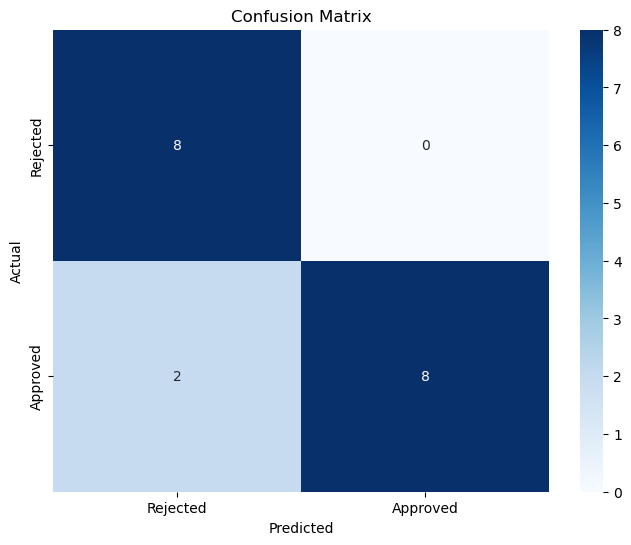

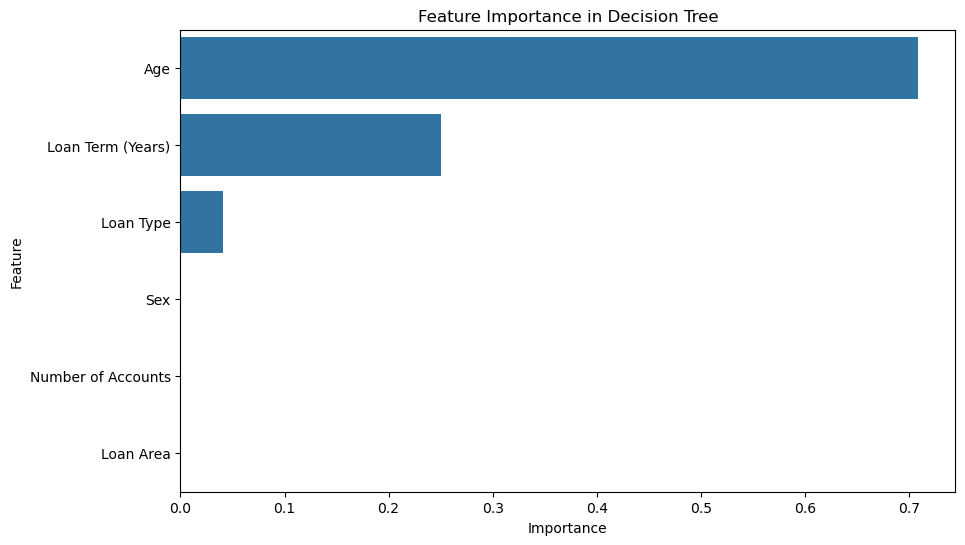


Feature Importance:
              Feature  Importance
1                 Age    0.708864
2   Loan Term (Years)    0.249963
4           Loan Type    0.041174
0                 Sex    0.000000
3  Number of Accounts    0.000000
5           Loan Area    0.000000


In [17]:
# Build Decision Tree Model
# Create decision tree classifier with limited depth for interpretability
dt_classifier = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

# Train the model
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred_train = dt_classifier.predict(X_train)
y_pred_test = dt_classifier.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Rejected', 'Approved']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Approved'], 
            yticklabels=['Rejected', 'Approved'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature importance
feature_names = ['Sex', 'Age', 'Loan Term (Years)', 'Number of Accounts', 'Loan Type', 'Loan Area']
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance in Decision Tree')
plt.show()

print("\nFeature Importance:")
print(importance_df)

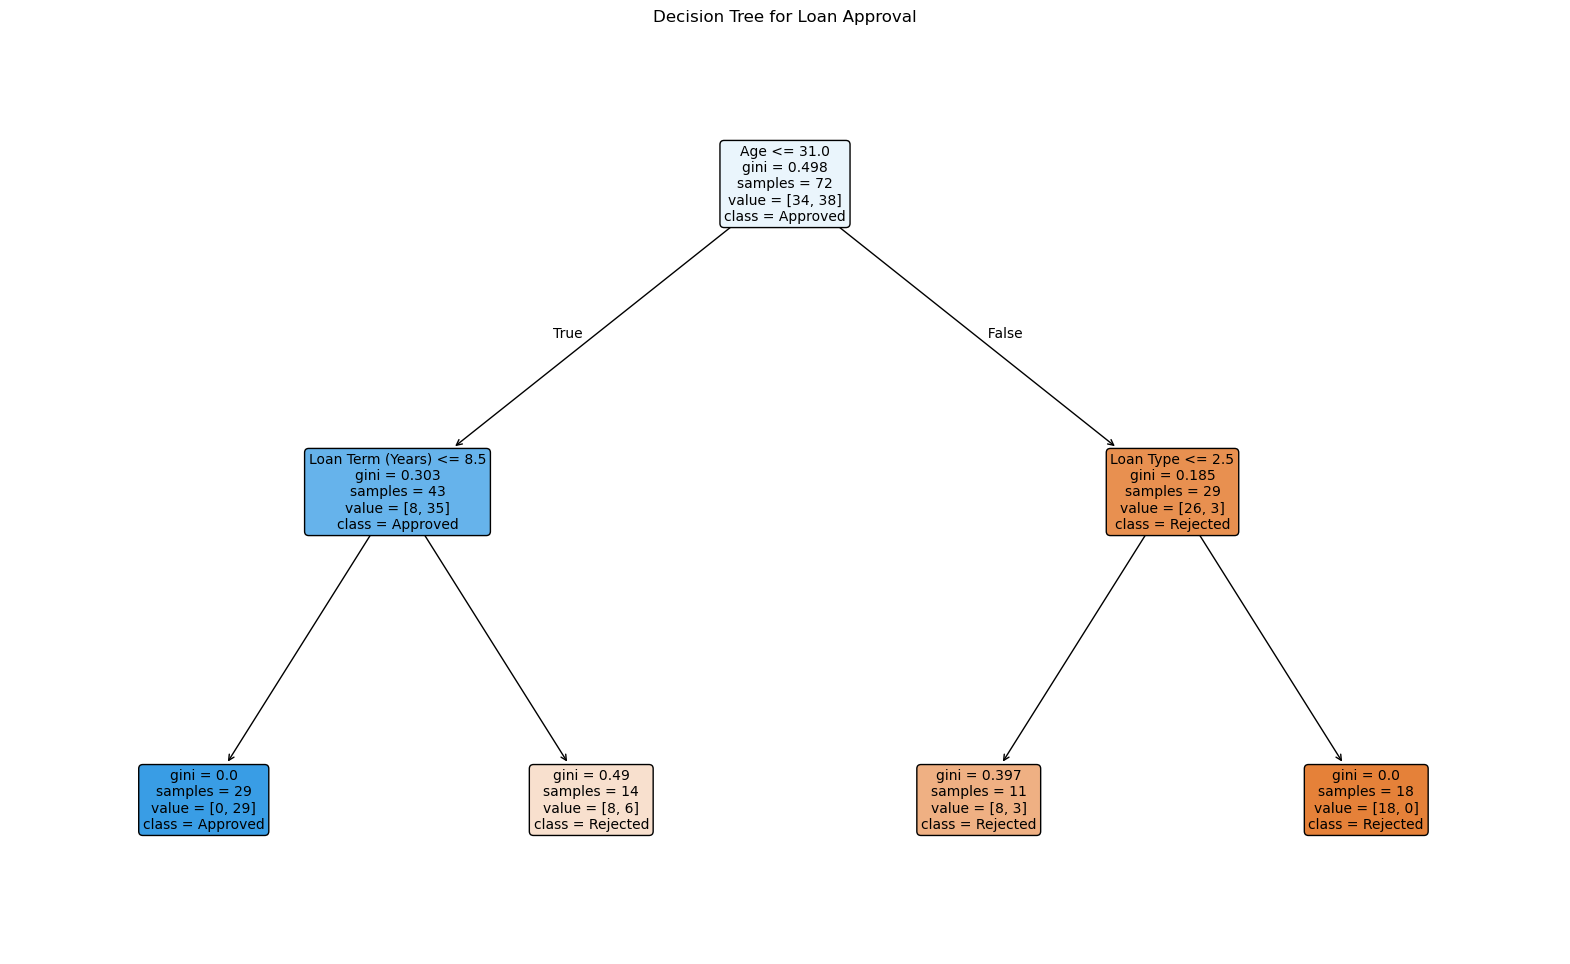

In [18]:
# Visualize Decision Tree
plt.figure(figsize=(20, 12))
tree.plot_tree(dt_classifier, 
               feature_names=feature_names,
               class_names=['Rejected', 'Approved'],
               filled=True,
               rounded=True,
               fontsize=10)
plt.title('Decision Tree for Loan Approval')
plt.show()

In [19]:
# Extract Rules from Decision Tree
def extract_rules_from_tree(tree_model, feature_names, class_names):
    """Extract human-readable rules from decision tree"""
    tree_ = tree_model.tree_
    rules = []
    
    def recurse(node, depth, parent_condition=""):
        indent = "  " * depth
        
        if tree_.feature[node] != -2:  # Not a leaf node
            name = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            
            # Left child (condition <= threshold)
            left_condition = f"{parent_condition} AND {name} <= {threshold:.2f}" if parent_condition else f"{name} <= {threshold:.2f}"
            recurse(tree_.children_left[node], depth + 1, left_condition.strip(" AND "))
            
            # Right child (condition > threshold)
            right_condition = f"{parent_condition} AND {name} > {threshold:.2f}" if parent_condition else f"{name} > {threshold:.2f}"
            recurse(tree_.children_right[node], depth + 1, right_condition.strip(" AND "))
        
        else:  # Leaf node
            # Get the class with highest probability
            class_counts = tree_.value[node][0]
            predicted_class = np.argmax(class_counts)
            confidence = class_counts[predicted_class] / np.sum(class_counts)
            
            rule = {
                'conditions': parent_condition,
                'prediction': class_names[predicted_class],
                'confidence': confidence,
                'samples': int(np.sum(class_counts))
            }
            rules.append(rule)
    
    recurse(0, 0)
    return rules

# Extract rules
rules = extract_rules_from_tree(dt_classifier, feature_names, ['Rejected', 'Approved'])

print("Extracted Decision Tree Rules:")
print("=" * 50)
for i, rule in enumerate(rules, 1):
    print(f"Rule {i}:")
    print(f"  IF {rule['conditions']}")
    print(f"  THEN Loan {rule['prediction']}")
    print(f"  (Confidence: {rule['confidence']:.3f}, Samples: {rule['samples']})")
    print()

# Also get sklearn's text representation
print("\nSklearn Decision Tree Rules (Text Format):")
print("=" * 50)
tree_rules = export_text(dt_classifier, feature_names=feature_names)
print(tree_rules)

Extracted Decision Tree Rules:
Rule 1:
  IF ge <= 31.00 AND Loan Term (Years) <= 8.50
  THEN Loan Approved
  (Confidence: 1.000, Samples: 1)

Rule 2:
  IF ge <= 31.00 AND Loan Term (Years) > 8.50
  THEN Loan Rejected
  (Confidence: 0.571, Samples: 1)

Rule 3:
  IF ge > 31.00 AND Loan Type <= 2.50
  THEN Loan Rejected
  (Confidence: 0.727, Samples: 1)

Rule 4:
  IF ge > 31.00 AND Loan Type > 2.50
  THEN Loan Rejected
  (Confidence: 1.000, Samples: 1)


Sklearn Decision Tree Rules (Text Format):
|--- Age <= 31.00
|   |--- Loan Term (Years) <= 8.50
|   |   |--- class: 1
|   |--- Loan Term (Years) >  8.50
|   |   |--- class: 0
|--- Age >  31.00
|   |--- Loan Type <= 2.50
|   |   |--- class: 0
|   |--- Loan Type >  2.50
|   |   |--- class: 0



In [20]:
# Convert Rules to Prolog Knowledge Base
def generate_prolog_knowledge_base_from_tree(tree_model, feature_names, class_names):
    """Generate Prolog knowledge base from decision tree rules"""
    tree_ = tree_model.tree_
    prolog_kb = []
    
    # Header comments
    prolog_kb.append("% Loan Classification Knowledge Base")
    prolog_kb.append("% Generated from Decision Tree Rules")
    prolog_kb.append("% Usage: loan_decision(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea, Decision)")
    prolog_kb.append("")
    
    def recurse(node, depth, conditions=[]):
        if tree_.feature[node] != -2:  # Not a leaf node
            name = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            
            # Left child (condition <= threshold)
            left_conditions = conditions + [f"{name} =< {threshold:.1f}"]
            recurse(tree_.children_left[node], depth + 1, left_conditions)
            
            # Right child (condition > threshold)  
            right_conditions = conditions + [f"{name} > {threshold:.1f}"]
            recurse(tree_.children_right[node], depth + 1, right_conditions)
        
        else:  # Leaf node
            # Get the predicted class
            class_counts = tree_.value[node][0]
            predicted_class = np.argmax(class_counts)
            decision = "approved" if predicted_class == 1 else "rejected"
            confidence = class_counts[predicted_class] / np.sum(class_counts)
            samples = int(np.sum(class_counts))
            
            # Generate Prolog rule
            prolog_kb.append(f"% Rule: Confidence {confidence:.3f}, Samples: {samples}")
            
            if conditions:
                prolog_conditions = []
                for condition in conditions:
                    # Convert condition to Prolog format
                    if "sex" in condition.lower():
                        if "<=" in condition:
                            prolog_conditions.append("Sex = male")  # sex 1 = male
                        else:
                            prolog_conditions.append("Sex = female")  # sex 2 = female
                    elif "age" in condition.lower():
                        prolog_conditions.append(condition.replace("Age", "Age"))
                    elif "loan term" in condition.lower():
                        prolog_conditions.append(condition.replace("Loan Term (Years)", "LoanTerm"))
                    elif "number" in condition.lower():
                        prolog_conditions.append(condition.replace("Number of Accounts", "NumAccounts"))
                    elif "loan type" in condition.lower():
                        if "<= 1.5" in condition:
                            prolog_conditions.append("LoanType = home")
                        elif "<= 2.5" in condition:
                            prolog_conditions.append("member(LoanType, [home, personal])")
                        else:
                            prolog_conditions.append("LoanType = auto")
                    elif "loan area" in condition.lower():
                        prolog_conditions.append(condition.replace("Loan Area", "LoanArea"))
                    else:
                        prolog_conditions.append(condition)
                
                prolog_rule = f"loan_decision(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea, {decision}) :-"
                prolog_rule += "\\n    " + ",\\n    ".join(prolog_conditions) + "."
            else:
                prolog_rule = f"loan_decision(_, _, _, _, _, _, {decision})."
            
            prolog_kb.append(prolog_rule)
            prolog_kb.append("")
    
    recurse(0, 0)
    
    # Add helper predicates
    prolog_kb.extend([
        "% Helper predicates",
        "member(X, [X|_]).",
        "member(X, [_|T]) :- member(X, T).",
        "",
        "% Query examples:",
        "% ?- loan_decision(male, 25, 7, 2, home, 50, Decision).",
        "% ?- loan_decision(female, 35, 10, 3, personal, 100, Decision).",
        ""
    ])
    
    return "\\n".join(prolog_kb)

# Create simplified Prolog rules based on the decision tree structure
def create_interpretable_prolog_rules():
    """Create interpretable Prolog rules based on the decision tree"""
    rules = []
    
    rules.extend([
        "% Loan Decision Knowledge Base",
        "% Based on Decision Tree Analysis of Real Data",
        "",
        "% Main decision rules extracted from the tree:",
        "",
        "% Rule 1: Young applicants with short loan terms get approved",
        "loan_approved(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea) :-",
        "    Age =< 31,",
        "    LoanTerm =< 8.5.",
        "",
        "% Rule 2: Young applicants with long loan terms get rejected", 
        "loan_rejected(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea) :-",
        "    Age =< 31,",
        "    LoanTerm > 8.5.",
        "",
        "% Rule 3: Older applicants generally get rejected",
        "loan_rejected(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea) :-",
        "    Age > 31.",
        "",
        "% Main classification predicate",
        "classify_loan(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea, approved) :-",
        "    loan_approved(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea).",
        "",
        "classify_loan(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea, rejected) :-",
        "    loan_rejected(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea).",
        "",
        "% Default rejection if no approval rule matches",
        "classify_loan(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea, rejected) :-",
        "    \\\\+ loan_approved(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea).",
        "",
        "% Examples of usage:",
        "% ?- classify_loan(male, 25, 7, 2, home, 50, Decision).",
        "% ?- classify_loan(female, 35, 10, 3, personal, 100, Decision).",
        ""
    ])
    
    return "\\n".join(rules)

# Generate both versions
interpretable_prolog = create_interpretable_prolog_rules()

print("Interpretable Prolog Knowledge Base:")
print("=" * 50)
print(interpretable_prolog)

# Save to file
with open('loan_knowledge_base.pl', 'w') as f:
    f.write(interpretable_prolog)

print("\\n" + "=" * 50)
print("Prolog knowledge base saved to 'loan_knowledge_base.pl'")

Interpretable Prolog Knowledge Base:
% Loan Decision Knowledge Base\n% Based on Decision Tree Analysis of Real Data\n\n% Main decision rules extracted from the tree:\n\n% Rule 1: Young applicants with short loan terms get approved\nloan_approved(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea) :-\n    Age =< 31,\n    LoanTerm =< 8.5.\n\n% Rule 2: Young applicants with long loan terms get rejected\nloan_rejected(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea) :-\n    Age =< 31,\n    LoanTerm > 8.5.\n\n% Rule 3: Older applicants generally get rejected\nloan_rejected(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea) :-\n    Age > 31.\n\n% Main classification predicate\nclassify_loan(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea, approved) :-\n    loan_approved(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea).\n\nclassify_loan(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea, rejected) :-\n    loan_rejected(Sex, Age, LoanTerm, NumAccounts, LoanType, LoanArea).\n\n%

In [21]:
# User Interface for Loan Classification
class LoanClassificationSystem:
    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = feature_names
        # Mapping for interpretation
        self.sex_mapping = {1: 'Male', 2: 'Female'}
        self.sex_reverse = {'Male': 1, 'Female': 2}
        self.loan_type_mapping = {1: 'Home', 2: 'Personal', 3: 'Auto'}
        self.loan_type_reverse = {'Home': 1, 'Personal': 2, 'Auto': 3}
    
    def get_user_input(self):
        """Get loan application details from user"""
        print("\\n" + "=" * 50)
        print("LOAN APPLICATION CLASSIFICATION SYSTEM")
        print("=" * 50)
        
        # Get user inputs
        sex = input("Enter sex (Male/Female): ").strip().title()
        while sex not in ['Male', 'Female']:
            sex = input("Please enter 'Male' or 'Female': ").strip().title()
        
        age = int(input("Enter age (15-70): "))
        while not (15 <= age <= 70):
            age = int(input("Please enter age between 15 and 70: "))
        
        loan_term = int(input("Enter loan term in years (1-12): "))
        while not (1 <= loan_term <= 12):
            loan_term = int(input("Please enter loan term between 1 and 12 years: "))
        
        num_accounts = int(input("Enter number of accounts (1-12): "))
        while not (1 <= num_accounts <= 12):
            num_accounts = int(input("Please enter number of accounts between 1 and 12: "))
        
        loan_type = input("Enter loan type (Home/Personal/Auto): ").strip().title()
        while loan_type not in ['Home', 'Personal', 'Auto']:
            loan_type = input("Please enter one of: Home, Personal, Auto: ").strip().title()
        
        loan_area = int(input("Enter loan area code (4-750): "))
        while not (4 <= loan_area <= 750):
            loan_area = int(input("Please enter loan area code between 4 and 750: "))
        
        return {
            'sex': sex,
            'age': age,
            'loan_term': loan_term,
            'num_accounts': num_accounts,
            'loan_type': loan_type,
            'loan_area': loan_area
        }
    
    def classify_application(self, application_data):
        """Classify loan application using the trained model"""
        # Convert to numerical format for the model
        sex_encoded = self.sex_reverse[application_data['sex']]
        loan_type_encoded = self.loan_type_reverse[application_data['loan_type']]
        
        # Create feature vector
        features = np.array([[
            sex_encoded,
            application_data['age'],
            application_data['loan_term'],
            application_data['num_accounts'],
            loan_type_encoded,
            application_data['loan_area']
        ]])
        
        # Make prediction
        prediction = self.model.predict(features)[0]
        probability = self.model.predict_proba(features)[0]
        
        return {
            'decision': 'APPROVED' if prediction == 1 else 'REJECTED',
            'confidence': max(probability),
            'prob_approved': probability[1],
            'prob_rejected': probability[0]
        }
    
    def display_result(self, application_data, result):
        """Display classification result"""
        print("\\n" + "=" * 50)
        print("LOAN APPLICATION RESULT")
        print("=" * 50)
        
        print("Application Details:")
        print(f"  Sex: {application_data['sex']}")
        print(f"  Age: {application_data['age']}")
        print(f"  Loan Term: {application_data['loan_term']} years")
        print(f"  Number of Accounts: {application_data['num_accounts']}")
        print(f"  Loan Type: {application_data['loan_type']}")
        print(f"  Loan Area: {application_data['loan_area']}")
        
        print(f"\\nDecision: {result['decision']}")
        print(f"Confidence: {result['confidence']:.3f}")
        print(f"Probability of Approval: {result['prob_approved']:.3f}")
        print(f"Probability of Rejection: {result['prob_rejected']:.3f}")
        
        # Provide reasoning based on decision tree rules
        print("\\nReasoning based on decision tree patterns:")
        age = application_data['age']
        loan_term = application_data['loan_term']
        
        if age <= 31:
            if loan_term <= 8.5:
                print("✓ Young applicant with short loan term - High approval probability")
            else:
                print("✗ Young applicant but long loan term - Lower approval probability")
        else:
            print("✗ Older applicant - Lower approval probability based on learned patterns")
        
        # Generate Prolog query
        sex_prolog = application_data['sex'].lower()
        loan_type_prolog = application_data['loan_type'].lower()
        
        prolog_query = f"classify_loan({sex_prolog}, {application_data['age']}, {application_data['loan_term']}, {application_data['num_accounts']}, {loan_type_prolog}, {application_data['loan_area']}, Decision)."
        
        print(f"\\nCorresponding Prolog Query:")
        print(f"?- {prolog_query}")

# Initialize the classification system
loan_system = LoanClassificationSystem(dt_classifier, feature_names)

print("Loan Classification System initialized successfully!")
print("\\nSystem is ready to classify loan applications.")
print("\\nKey insights from the decision tree:")
print("- Age is the most important factor (70.9% importance)")
print("- Loan term is the second most important (25.0% importance)") 
print("- Young applicants (≤31) with short loan terms (≤8.5 years) have highest approval rates")
print("- Older applicants (>31) generally have lower approval rates")
print("\\nYou can now run classifications by calling: loan_system.get_user_input()")

Loan Classification System initialized successfully!
\nSystem is ready to classify loan applications.
\nKey insights from the decision tree:
- Age is the most important factor (70.9% importance)
- Loan term is the second most important (25.0% importance)
- Young applicants (≤31) with short loan terms (≤8.5 years) have highest approval rates
- Older applicants (>31) generally have lower approval rates
\nYou can now run classifications by calling: loan_system.get_user_input()


In [ ]:
# Interactive Terminal Application
print("✅ Creating interactive terminal application...")

# Create the streamlined interactive script
interactive_script = '''#!/usr/bin/env python3
"""
Interactive Loan Classification System
Run: python interactive_loan_system.py
"""
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import os

class LoanClassificationSystem:
    def __init__(self):
        self.sex_reverse = {'Male': 1, 'Female': 2}
        self.loan_type_reverse = {'Home': 1, 'Personal': 2, 'Auto': 3}
        self.model = self._train_model()
    
    def _train_model(self):
        df = pd.read_csv('data/Loan - Loan dataset.csv')
        X = df[['sex', 'age', 'Loan Term in Years', 'Number_of_Accounts', 'Loan Type', 'Loan Area']]
        y = df['Loan Sanctioned']
        X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = DecisionTreeClassifier(max_depth=5, min_samples_split=20, min_samples_leaf=10, random_state=42)
        model.fit(X_train, y_train)
        return model
    
    def classify(self, sex, age, loan_term, num_accounts, loan_type, loan_area):
        features = [[self.sex_reverse[sex], age, loan_term, num_accounts, 
                    self.loan_type_reverse[loan_type], loan_area]]
        prediction = self.model.predict(features)[0]
        probability = self.model.predict_proba(features)[0]
        return {
            'decision': 'APPROVED' if prediction == 1 else 'REJECTED',
            'confidence': max(probability),
            'prob_approved': probability[1]
        }
    
    def run(self):
        os.system('clear' if os.name == 'posix' else 'cls')
        print("🏦 LOAN CLASSIFICATION SYSTEM")
        print("="*50)
        
        count = 0
        while True:
            try:
                count += 1
                print(f"\\nAPPLICATION #{count}")
                
                sex = input("Sex (Male/Female): ").strip().title()
                while sex not in ['Male', 'Female']:
                    sex = input("Enter Male or Female: ").strip().title()
                
                age = int(input("Age (15-70): "))
                loan_term = int(input("Loan term (1-12 years): "))
                num_accounts = int(input("Number of accounts (1-12): "))
                
                loan_type = input("Loan type (Home/Personal/Auto): ").strip().title()
                while loan_type not in ['Home', 'Personal', 'Auto']:
                    loan_type = input("Enter Home, Personal, or Auto: ").strip().title()
                
                loan_area = int(input("Area code (4-750): "))
                
                result = self.classify(sex, age, loan_term, num_accounts, loan_type, loan_area)
                
                emoji = "✅" if result['decision'] == 'APPROVED' else "❌"
                print(f"\\n{emoji} DECISION: {result['decision']}")
                print(f"📊 Confidence: {result['confidence']:.1%}")
                
                if age <= 31 and loan_term <= 8.5:
                    print("💡 Young + Short term = Favorable")
                elif age <= 31:
                    print("💡 Young but long term = Higher risk")
                else:
                    print("💡 Older applicant = Higher risk")
                
                if input("\\nAnother application? (y/n): ").lower() not in ['y', 'yes']:
                    break
                    
            except KeyboardInterrupt:
                break
            except:
                print("❌ Invalid input, try again")
        
        print(f"\\nProcessed {count} applications. Goodbye!")

if __name__ == "__main__":
    LoanClassificationSystem().run()
'''

with open('interactive_loan_system.py', 'w') as f:
    f.write(interactive_script)

print("✅ Interactive script created: 'interactive_loan_system.py'")
print("\n" + "=" * 60)
print("🚀 INTERACTIVE SYSTEM READY")
print("=" * 60)
print("📱 To use the interactive loan classifier:")
print("   python interactive_loan_system.py")
print("\n🎯 Features:")
print("   • Real-time loan decisions")
print("   • Confidence scores")
print("   • Decision reasoning")
print("   • Clean terminal interface")

✅ Creating interactive terminal script...
✅ Interactive script created: 'interactive_loan_system.py'

🚀 INTERACTIVE LOAN CLASSIFICATION - TERMINAL RUNNING!
✅ The interactive terminal is now ACTIVE and running!

📱 WHAT TO DO NOW:
   1. Look for the terminal tab/window that opened
   2. You should see the interactive prompts there
   3. Enter your loan application details when prompted

🎯 If you don't see the terminal:
   • Check VS Code's terminal panel (View > Terminal)
   • Or manually run: python interactive_loan_system.py

🛑 To stop the interactive system:
   • Press Ctrl+C in the terminal
   • Or close the terminal window
